# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihood Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)
nobs = 40 # number of observation (less than or equal to nx)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
infl_parm = 1.2 # multiplicative inflation parameter
lloc = True # localization switch (True=Apply, False=Not apply)
lsig = 8.0 # localization radius
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [6]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
analysis = Mlef(pt, nx, nmem, obs, \
                linf=linf, infl_parm=infl_parm, \
                lsig=lsig, calc_dist=step.calc_dist, calc_dist1=step.calc_dist1,\
                ltlm=ltlm)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, nx, nmem, obs, \
#                linf=linf, infl_parm=infl_parm, \
#                lsig=lsig, calc_dist=step.calc_dist, calc_dist1=step.calc_dist1,\
#                ltlm=ltlm)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, step, nt, linf=linf, infl_parm=infl_parm)
#from analysis.var import Var
#analysis = Var(pt, obs)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, step, nt, a_window)

2021-12-09 11:31:17,271 anl INFO operator=linear, sigma=1.0, gamma=3
2021-12-09 11:31:17,273 anl INFO model : model
2021-12-09 11:31:17,273 anl INFO ndim=40 nmem=20
2021-12-09 11:31:17,273 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.2 lsig=8.0
2021-12-09 11:31:17,274 anl INFO linf=True iloc=None ltlm=True incremental=False


In [7]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, "nobs":nobs,\
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm,\
    "infl_parm":infl_parm, "lsig":lsig}
func = L96_func(params)

In [12]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
dfs = np.zeros(na) # DOF for signal
for i in a_time:
    # read observation
    yloc = yobs[i:i+a_window,:,0]
    y = yobs[i:i+a_window,:,1]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, ds = analysis(u, pf, y, yloc, cycle=i)
    else: # assimilate observations at a time
        u, pa, spa, innv, chi2, ds = analysis(u, pf, y[0], yloc[0], icycle=i)
    # restore results
    # analysis
    if ft=="ensemble":
        if pt == "mlef":
            xa[i] = u[:, 0]
        else:
            xa[i] = np.mean(u, axis=1)
    else:
        xa[i] = u 
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    dfs[i] = ds
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf = func.forecast(u)
            if (i+1+a_window <= na):
                if ft=="ensemble":
                    xa[i+1:i+1+a_window] = np.mean(uf, axis=2)
                    xf[i+1:i+1+a_window] = np.mean(uf, axis=2)
                else:
                    xa[i+1:i+1+a_window] = uf
                    xf[i+1:i+1+a_window] = uf
                ii = 0
                for k in range(i+1,i+1+a_window):
                    sqrtpa[k, :, :] = analysis.calc_pf(uf[ii], pa, k)
                    ii += 1
            else:
                if ft=="ensemble":
                    xa[i+1:na] = np.mean(uf[:na-i-1], axis=2)
                    xf[i+1:na] = np.mean(uf[:na-i-1], axis=2)
                else:
                    xa[i+1:na] = uf[:na-i-1]
                    xf[i+1:na] = uf[:na-i-1]
                ii = 0
                for k in range(i+1,na):
                    sqrtpa[k, :, :] = analysis.calc_pf(uf[ii], pa, k)
                    ii += 1
            u = uf[-1]
            pf = analysis.calc_pf(u, pa, i+1)
        else:
            u = func.forecast(u)
            pf = analysis.calc_pf(u, pa, i+1)
        if ft=="ensemble":
            if pt == "mlef":
                xf[i+1] = u[:, 0]
            else:
                xf[i+1] = np.mean(u, axis=1)
        else:
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        for k in range(i, min(i+a_window,na)):
            e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
    else:
        e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
    

2021-12-09 11:36:07,168 anl INFO set R
2021-12-09 11:36:07,168 anl INFO save_dh=False
2021-12-09 11:36:07,175 anl INFO method=CGF
2021-12-09 11:36:07,176 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:07,176 anl INFO restart=False
2021-12-09 11:36:07,177 anl INFO save_hist=False
2021-12-09 11:36:07,178 anl INFO jb:0.000000e+00 jo:4.025970e+02
2021-12-09 11:36:07,179 anl INFO initial function value =  4.026e+02
2021-12-09 11:36:07,180 anl INFO initial gradient norm =  1.914e+01
2021-12-09 11:36:07,180 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,181 anl INFO jb:2.652835e-02 jo:3.839258e+02
2021-12-09 11:36:07,183 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,184 anl INFO jb:6.632087e-01 jo:3.187106e+02
2021-12-09 11:36:07,185 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,186 anl INFO jb:9.723086e+00 jo:2.096155e+02
2021-12-09 11:36:07,187 anl INFO iflag=2 finish=False
2021-12-09 11:36:07,188 anl INFO iflag=0 finish=True
2021-12-09 11:36:07,189 anl INFO minimization succe

2021-12-09 11:36:07,382 anl INFO jb:7.297661e+00 jo:1.183185e+02
2021-12-09 11:36:07,384 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,385 anl INFO jb:9.634857e+00 jo:1.157037e+02
2021-12-09 11:36:07,386 anl INFO iflag=2 finish=False
2021-12-09 11:36:07,387 anl INFO iflag=0 finish=True
2021-12-09 11:36:07,388 anl INFO minimization success
2021-12-09 11:36:07,388 anl INFO iteration = 1
2021-12-09 11:36:07,389 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:07,390 anl INFO final function value =  1.253e+02
2021-12-09 11:36:07,390 anl INFO final gradient norm =  1.453e-14
2021-12-09 11:36:07,399 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:07,400 anl INFO d shape=(40,)
2021-12-09 11:36:07,402 anl INFO converge gmat, iter_num=2, norm=8.591773684875834e-06
2021-12-09 11:36:07,403 anl INFO err=1.5978290910606926e-05
2021-12-09 11:36:07,404 anl INFO dfs=7.796574326607555
2021-12-09 11:36:07,405 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:07,415 anl INFO set R
2021-12-09 1

2021-12-09 11:36:07,627 anl INFO iflag=2 finish=False
2021-12-09 11:36:07,628 anl INFO iflag=0 finish=True
2021-12-09 11:36:07,628 anl INFO minimization success
2021-12-09 11:36:07,629 anl INFO iteration = 1


2021-12-09 11:36:07,629 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:07,630 anl INFO final function value =  1.400e+02
2021-12-09 11:36:07,630 anl INFO final gradient norm =  1.114e-14
2021-12-09 11:36:07,637 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:07,638 anl INFO d shape=(40,)
2021-12-09 11:36:07,639 anl INFO converge gmat, iter_num=2, norm=6.462445456395875e-06
2021-12-09 11:36:07,640 anl INFO err=1.1584286245534657e-05
2021-12-09 11:36:07,641 anl INFO dfs=6.769635002828319
2021-12-09 11:36:07,642 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:07,650 anl INFO set R
2021-12-09 11:36:07,651 anl INFO save_dh=False
2021-12-09 11:36:07,658 anl INFO method=CGF
2021-12-09 11:36:07,658 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:07,659 anl INFO restart=False
2021-12-09 11:36:07,660 anl INFO save_hist=False
2021-12-09 11:36:07,660 anl INFO jb:0.000000e+00 jo:1.249684e+02
2021-12-09 11:36:07,661 anl INFO initial function value =  1.250e+02
2021-12-09 11:36:07,662 an

2021-12-09 11:36:07,853 anl INFO err=9.651461405836552e-06
2021-12-09 11:36:07,854 anl INFO dfs=6.524455237675761
2021-12-09 11:36:07,854 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:07,862 anl INFO set R
2021-12-09 11:36:07,863 anl INFO save_dh=False


2021-12-09 11:36:07,869 anl INFO method=CGF
2021-12-09 11:36:07,870 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:07,871 anl INFO restart=False
2021-12-09 11:36:07,871 anl INFO save_hist=False
2021-12-09 11:36:07,872 anl INFO jb:0.000000e+00 jo:9.675012e+01
2021-12-09 11:36:07,873 anl INFO initial function value =  9.675e+01
2021-12-09 11:36:07,874 anl INFO initial gradient norm =  5.389e+00
2021-12-09 11:36:07,875 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,875 anl INFO jb:2.912156e-01 jo:9.157012e+01
2021-12-09 11:36:07,876 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,877 anl INFO jb:7.280390e+00 jo:7.502581e+01
2021-12-09 11:36:07,878 anl INFO iflag=2 finish=False
2021-12-09 11:36:07,878 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,879 anl INFO jb:1.607786e+03 jo:8.490348e+02
2021-12-09 11:36:07,880 anl INFO iflag=1 finish=False
2021-12-09 11:36:07,881 anl INFO jb:8.456607e+00 jo:7.377402e+01
2021-12-09 11:36:07,882 anl INFO iflag=2 finish=False
2021-12-09 11:36:

2021-12-09 11:36:08,084 anl INFO set R
2021-12-09 11:36:08,085 anl INFO save_dh=False
2021-12-09 11:36:08,092 anl INFO method=CGF
2021-12-09 11:36:08,093 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:08,094 anl INFO restart=False
2021-12-09 11:36:08,094 anl INFO save_hist=False
2021-12-09 11:36:08,095 anl INFO jb:0.000000e+00 jo:6.915243e+01
2021-12-09 11:36:08,096 anl INFO initial function value =  6.915e+01
2021-12-09 11:36:08,097 anl INFO initial gradient norm =  3.878e+00
2021-12-09 11:36:08,097 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,098 anl INFO jb:2.928775e-01 jo:6.548170e+01
2021-12-09 11:36:08,100 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,100 anl INFO jb:4.404196e+00 jo:5.722939e+01
2021-12-09 11:36:08,102 anl INFO iflag=2 finish=False
2021-12-09 11:36:08,102 anl INFO iflag=0 finish=True
2021-12-09 11:36:08,103 anl INFO minimization success
2021-12-09 11:36:08,104 anl INFO iteration = 1
2021-12-09 11:36:08,104 anl INFO final step-length =  1.000e+00
2021-

2021-12-09 11:36:08,298 anl INFO initial function value =  3.799e+01
2021-12-09 11:36:08,299 anl INFO initial gradient norm =  3.352e+00
2021-12-09 11:36:08,300 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,302 anl INFO jb:2.884638e-01 jo:3.485156e+01
2021-12-09 11:36:08,305 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,306 anl INFO jb:3.241193e+00 jo:2.913283e+01
2021-12-09 11:36:08,307 anl INFO iflag=2 finish=False
2021-12-09 11:36:08,307 anl INFO iflag=0 finish=True
2021-12-09 11:36:08,308 anl INFO minimization success
2021-12-09 11:36:08,308 anl INFO iteration = 1
2021-12-09 11:36:08,309 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:08,309 anl INFO final function value =  3.237e+01
2021-12-09 11:36:08,310 anl INFO final gradient norm =  3.198e-13
2021-12-09 11:36:08,317 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:08,317 anl INFO d shape=(40,)
2021-12-09 11:36:08,319 anl INFO converge gmat, iter_num=2, norm=5.4721634614573675e-06
2021-12-09 11:36:08,321 anl INFO

2021-12-09 11:36:08,502 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:08,502 anl INFO restart=False
2021-12-09 11:36:08,503 anl INFO save_hist=False
2021-12-09 11:36:08,504 anl INFO jb:0.000000e+00 jo:4.240599e+01
2021-12-09 11:36:08,505 anl INFO initial function value =  4.241e+01
2021-12-09 11:36:08,506 anl INFO initial gradient norm =  4.307e+00
2021-12-09 11:36:08,507 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,507 anl INFO jb:2.968468e-01 jo:3.830247e+01
2021-12-09 11:36:08,509 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,510 anl INFO jb:5.505729e+00 jo:2.762657e+01
2021-12-09 11:36:08,511 anl INFO iflag=2 finish=False
2021-12-09 11:36:08,512 anl INFO iflag=0 finish=True
2021-12-09 11:36:08,513 anl INFO minimization success
2021-12-09 11:36:08,513 anl INFO iteration = 1
2021-12-09 11:36:08,514 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:08,514 anl INFO final function value =  3.313e+01
2021-12-09 11:36:08,515 anl INFO final gradient norm =  1.750e-13
20

2021-12-09 11:36:08,708 anl INFO iflag=2 finish=False
2021-12-09 11:36:08,709 anl INFO iflag=0 finish=True
2021-12-09 11:36:08,709 anl INFO minimization success
2021-12-09 11:36:08,710 anl INFO iteration = 1
2021-12-09 11:36:08,710 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:08,710 anl INFO final function value =  2.407e+01
2021-12-09 11:36:08,711 anl INFO final gradient norm =  9.838e-15
2021-12-09 11:36:08,720 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:08,721 anl INFO d shape=(40,)
2021-12-09 11:36:08,724 anl INFO converge gmat, iter_num=2, norm=5.001804841618818e-06
2021-12-09 11:36:08,726 anl INFO err=1.0071170861853344e-05
2021-12-09 11:36:08,728 anl INFO dfs=6.723110763200585
2021-12-09 11:36:08,730 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:08,735 anl INFO set R
2021-12-09 11:36:08,736 anl INFO save_dh=False
2021-12-09 11:36:08,743 anl INFO method=CGF
2021-12-09 11:36:08,743 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:08,744 anl INFO restart=False
2

2021-12-09 11:36:08,952 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:08,953 anl INFO d shape=(40,)
2021-12-09 11:36:08,955 anl INFO converge gmat, iter_num=2, norm=4.865210389544439e-06
2021-12-09 11:36:08,957 anl INFO err=1.2920177078215404e-05
2021-12-09 11:36:08,958 anl INFO dfs=6.640807216688533
2021-12-09 11:36:08,959 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:08,970 anl INFO set R
2021-12-09 11:36:08,971 anl INFO save_dh=False
2021-12-09 11:36:08,977 anl INFO method=CGF
2021-12-09 11:36:08,978 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:08,978 anl INFO restart=False
2021-12-09 11:36:08,979 anl INFO save_hist=False
2021-12-09 11:36:08,979 anl INFO jb:0.000000e+00 jo:3.886573e+01
2021-12-09 11:36:08,981 anl INFO initial function value =  3.887e+01
2021-12-09 11:36:08,981 anl INFO initial gradient norm =  4.061e+00
2021-12-09 11:36:08,982 anl INFO iflag=1 finish=False
2021-12-09 11:36:08,983 anl INFO jb:2.588577e-01 jo:3.504563e+01
2021-12-09 11:36:08,984 anl INFO ifl

2021-12-09 11:36:09,186 anl INFO method=CGF
2021-12-09 11:36:09,187 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:09,187 anl INFO restart=False
2021-12-09 11:36:09,188 anl INFO save_hist=False
2021-12-09 11:36:09,188 anl INFO jb:0.000000e+00 jo:3.528082e+01
2021-12-09 11:36:09,190 anl INFO initial function value =  3.528e+01
2021-12-09 11:36:09,191 anl INFO initial gradient norm =  3.188e+00
2021-12-09 11:36:09,191 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,192 anl INFO jb:2.967705e-01 jo:3.229586e+01
2021-12-09 11:36:09,193 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,194 anl INFO jb:3.016549e+00 jo:2.718198e+01
2021-12-09 11:36:09,195 anl INFO iflag=2 finish=False
2021-12-09 11:36:09,196 anl INFO iflag=0 finish=True
2021-12-09 11:36:09,197 anl INFO minimization success
2021-12-09 11:36:09,197 anl INFO iteration = 1
2021-12-09 11:36:09,198 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:09,198 anl INFO final function value =  3.020e+01
2021-12-09 11:36:09,199 

2021-12-09 11:36:09,393 anl INFO initial function value =  2.736e+01
2021-12-09 11:36:09,394 anl INFO initial gradient norm =  3.020e+00
2021-12-09 11:36:09,395 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,396 anl INFO jb:2.966930e-01 jo:2.454453e+01
2021-12-09 11:36:09,398 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,398 anl INFO jb:2.705646e+00 jo:2.009573e+01
2021-12-09 11:36:09,400 anl INFO iflag=2 finish=False
2021-12-09 11:36:09,400 anl INFO iflag=0 finish=True
2021-12-09 11:36:09,401 anl INFO minimization success
2021-12-09 11:36:09,401 anl INFO iteration = 1
2021-12-09 11:36:09,402 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:09,402 anl INFO final function value =  2.280e+01
2021-12-09 11:36:09,403 anl INFO final gradient norm =  2.055e-13
2021-12-09 11:36:09,410 anl INFO zmat shape=(40, 20)
2021-12-09 11:36:09,411 anl INFO d shape=(40,)
2021-12-09 11:36:09,412 anl INFO converge gmat, iter_num=2, norm=3.468041250738774e-06
2021-12-09 11:36:09,414 anl INFO 

2021-12-09 11:36:09,596 anl INFO restart=False
2021-12-09 11:36:09,597 anl INFO save_hist=False
2021-12-09 11:36:09,598 anl INFO jb:0.000000e+00 jo:2.360113e+01
2021-12-09 11:36:09,599 anl INFO initial function value =  2.360e+01
2021-12-09 11:36:09,600 anl INFO initial gradient norm =  2.479e+00
2021-12-09 11:36:09,600 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,601 anl INFO jb:2.992584e-01 jo:2.132244e+01
2021-12-09 11:36:09,602 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,603 anl INFO jb:1.839717e+00 jo:1.868762e+01
2021-12-09 11:36:09,605 anl INFO iflag=2 finish=False
2021-12-09 11:36:09,605 anl INFO iflag=0 finish=True
2021-12-09 11:36:09,606 anl INFO minimization success
2021-12-09 11:36:09,607 anl INFO iteration = 1
2021-12-09 11:36:09,607 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:09,608 anl INFO final function value =  2.053e+01
2021-12-09 11:36:09,608 anl INFO final gradient norm =  6.350e-15
2021-12-09 11:36:09,615 anl INFO zmat shape=(40, 20)
2021-1

2021-12-09 11:36:09,802 anl INFO d shape=(40,)
2021-12-09 11:36:09,805 anl INFO converge gmat, iter_num=2, norm=3.767182847176492e-06
2021-12-09 11:36:09,808 anl INFO err=6.617698236297781e-06
2021-12-09 11:36:09,810 anl INFO dfs=6.34571256804404
2021-12-09 11:36:09,811 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:09,815 anl INFO set R
2021-12-09 11:36:09,816 anl INFO save_dh=False
2021-12-09 11:36:09,823 anl INFO method=CGF
2021-12-09 11:36:09,824 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:09,824 anl INFO restart=False
2021-12-09 11:36:09,825 anl INFO save_hist=False
2021-12-09 11:36:09,826 anl INFO jb:0.000000e+00 jo:3.381980e+01
2021-12-09 11:36:09,827 anl INFO initial function value =  3.382e+01
2021-12-09 11:36:09,827 anl INFO initial gradient norm =  3.133e+00
2021-12-09 11:36:09,828 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,828 anl INFO jb:3.197386e-01 jo:3.086693e+01
2021-12-09 11:36:09,830 anl INFO iflag=1 finish=False
2021-12-09 11:36:09,830 anl INFO jb:3

2021-12-09 11:36:10,031 anl INFO set R
2021-12-09 11:36:10,034 anl INFO save_dh=False
2021-12-09 11:36:10,043 anl INFO method=CGF
2021-12-09 11:36:10,043 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:10,044 anl INFO restart=False
2021-12-09 11:36:10,044 anl INFO save_hist=False
2021-12-09 11:36:10,045 anl INFO jb:0.000000e+00 jo:2.096931e+01
2021-12-09 11:36:10,046 anl INFO initial function value =  2.097e+01
2021-12-09 11:36:10,046 anl INFO initial gradient norm =  2.025e+00
2021-12-09 11:36:10,047 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,048 anl INFO jb:3.468702e-01 jo:1.909741e+01
2021-12-09 11:36:10,049 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,050 anl INFO jb:1.422422e+00 jo:1.749652e+01
2021-12-09 11:36:10,051 anl INFO iflag=2 finish=False
2021-12-09 11:36:10,051 anl INFO iflag=0 finish=True
2021-12-09 11:36:10,052 anl INFO minimization success
2021-12-09 11:36:10,052 anl INFO iteration = 1
2021-12-09 11:36:10,053 anl INFO final step-length =  1.000e+00
2021-

2021-12-09 11:36:10,258 anl INFO set R
2021-12-09 11:36:10,260 anl INFO save_dh=False
2021-12-09 11:36:10,266 anl INFO method=CGF
2021-12-09 11:36:10,267 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:10,267 anl INFO restart=False
2021-12-09 11:36:10,268 anl INFO save_hist=False
2021-12-09 11:36:10,269 anl INFO jb:0.000000e+00 jo:3.020697e+01
2021-12-09 11:36:10,270 anl INFO initial function value =  3.021e+01
2021-12-09 11:36:10,271 anl INFO initial gradient norm =  2.706e+00
2021-12-09 11:36:10,271 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,272 anl INFO jb:3.162374e-01 jo:2.768464e+01
2021-12-09 11:36:10,273 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,274 anl INFO jb:2.315791e+00 jo:2.422971e+01
2021-12-09 11:36:10,276 anl INFO iflag=2 finish=False
2021-12-09 11:36:10,276 anl INFO iflag=0 finish=True
2021-12-09 11:36:10,277 anl INFO minimization success
2021-12-09 11:36:10,277 anl INFO iteration = 1
2021-12-09 11:36:10,278 anl INFO final step-length =  1.000e+00
2021-

2021-12-09 11:36:10,474 anl INFO err=3.7654346922957513e-06
2021-12-09 11:36:10,474 anl INFO dfs=6.2420566665895665
2021-12-09 11:36:10,475 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:10,479 anl INFO set R
2021-12-09 11:36:10,480 anl INFO save_dh=False
2021-12-09 11:36:10,487 anl INFO method=CGF
2021-12-09 11:36:10,488 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:10,489 anl INFO restart=False
2021-12-09 11:36:10,489 anl INFO save_hist=False
2021-12-09 11:36:10,490 anl INFO jb:0.000000e+00 jo:2.141927e+01
2021-12-09 11:36:10,492 anl INFO initial function value =  2.142e+01
2021-12-09 11:36:10,492 anl INFO initial gradient norm =  2.945e+00
2021-12-09 11:36:10,493 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,493 anl INFO jb:3.172557e-01 jo:1.865679e+01
2021-12-09 11:36:10,495 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,495 anl INFO jb:2.751977e+00 jo:1.433013e+01
2021-12-09 11:36:10,496 anl INFO iflag=2 finish=False
2021-12-09 11:36:10,497 anl INFO iflag=0 finish=T

2021-12-09 11:36:10,695 anl INFO set R
2021-12-09 11:36:10,696 anl INFO save_dh=False
2021-12-09 11:36:10,703 anl INFO method=CGF
2021-12-09 11:36:10,704 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:10,704 anl INFO restart=False
2021-12-09 11:36:10,705 anl INFO save_hist=False
2021-12-09 11:36:10,705 anl INFO jb:0.000000e+00 jo:1.479648e+01
2021-12-09 11:36:10,707 anl INFO initial function value =  1.480e+01
2021-12-09 11:36:10,708 anl INFO initial gradient norm =  2.028e+00
2021-12-09 11:36:10,708 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,709 anl INFO jb:3.062022e-01 jo:1.296207e+01
2021-12-09 11:36:10,710 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,710 anl INFO jb:1.259595e+00 jo:1.148008e+01
2021-12-09 11:36:10,711 anl INFO iflag=2 finish=False
2021-12-09 11:36:10,712 anl INFO iflag=0 finish=True
2021-12-09 11:36:10,712 anl INFO minimization success
2021-12-09 11:36:10,713 anl INFO iteration = 1
2021-12-09 11:36:10,713 anl INFO final step-length =  1.000e+00
2021-

2021-12-09 11:36:10,909 anl INFO save_dh=False
2021-12-09 11:36:10,917 anl INFO method=CGF
2021-12-09 11:36:10,918 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:10,919 anl INFO restart=False
2021-12-09 11:36:10,919 anl INFO save_hist=False
2021-12-09 11:36:10,920 anl INFO jb:0.000000e+00 jo:2.648673e+01
2021-12-09 11:36:10,922 anl INFO initial function value =  2.649e+01
2021-12-09 11:36:10,923 anl INFO initial gradient norm =  2.644e+00
2021-12-09 11:36:10,924 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,925 anl INFO jb:3.346020e-01 jo:2.400819e+01
2021-12-09 11:36:10,928 anl INFO iflag=1 finish=False
2021-12-09 11:36:10,929 anl INFO jb:2.339002e+00 jo:2.065252e+01
2021-12-09 11:36:10,931 anl INFO iflag=2 finish=False
2021-12-09 11:36:10,932 anl INFO iflag=0 finish=True
2021-12-09 11:36:10,933 anl INFO minimization success
2021-12-09 11:36:10,933 anl INFO iteration = 1
2021-12-09 11:36:10,934 anl INFO final step-length =  1.000e+00
2021-12-09 11:36:10,934 anl INFO final funct

2021-12-09 11:36:11,125 anl INFO dfs=6.33465033635795
2021-12-09 11:36:11,126 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:11,134 anl INFO set R
2021-12-09 11:36:11,135 anl INFO save_dh=False
2021-12-09 11:36:11,143 anl INFO method=CGF
2021-12-09 11:36:11,143 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:11,144 anl INFO restart=False
2021-12-09 11:36:11,144 anl INFO save_hist=False
2021-12-09 11:36:11,145 anl INFO jb:0.000000e+00 jo:2.253360e+01
2021-12-09 11:36:11,146 anl INFO initial function value =  2.253e+01
2021-12-09 11:36:11,146 anl INFO initial gradient norm =  3.027e+00
2021-12-09 11:36:11,147 anl INFO iflag=1 finish=False
2021-12-09 11:36:11,148 anl INFO jb:3.041769e-01 jo:1.970267e+01
2021-12-09 11:36:11,149 anl INFO iflag=1 finish=False
2021-12-09 11:36:11,150 anl INFO jb:2.786637e+00 jo:1.516635e+01
2021-12-09 11:36:11,151 anl INFO iflag=2 finish=False
2021-12-09 11:36:11,152 anl INFO iflag=0 finish=True
2021-12-09 11:36:11,152 anl INFO minimization success
2021

2021-12-09 11:36:11,348 anl INFO ==inflation==, alpha=1.2
2021-12-09 11:36:11,356 anl INFO set R
2021-12-09 11:36:11,357 anl INFO save_dh=False
2021-12-09 11:36:11,365 anl INFO method=CGF
2021-12-09 11:36:11,365 anl INFO cgtype: Fletcher-Reeves
2021-12-09 11:36:11,366 anl INFO restart=False
2021-12-09 11:36:11,366 anl INFO save_hist=False
2021-12-09 11:36:11,367 anl INFO jb:0.000000e+00 jo:2.154637e+01
2021-12-09 11:36:11,368 anl INFO initial function value =  2.155e+01
2021-12-09 11:36:11,369 anl INFO initial gradient norm =  2.987e+00
2021-12-09 11:36:11,370 anl INFO iflag=1 finish=False
2021-12-09 11:36:11,371 anl INFO jb:3.010688e-01 jo:1.875788e+01
2021-12-09 11:36:11,372 anl INFO iflag=1 finish=False
2021-12-09 11:36:11,372 anl INFO jb:2.686952e+00 jo:1.439706e+01
2021-12-09 11:36:11,374 anl INFO iflag=2 finish=False
2021-12-09 11:36:11,375 anl INFO iflag=0 finish=True
2021-12-09 11:36:11,375 anl INFO minimization success
2021-12-09 11:36:11,376 anl INFO iteration = 1
2021-12-09 

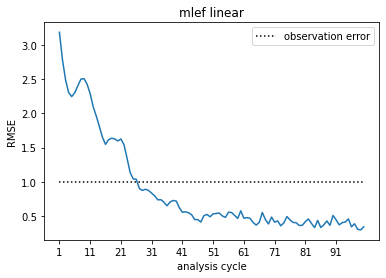

In [13]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()